# Описание проекта 


Клиентам компании «Мегалайн» предлагают два тарифных плана: Смарт и Ультра. Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

##### Тариф Смарт: 

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

##### Тариф Ультра: 

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей 
 
*Отдельно обратим внимание на:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута*

**Описание данных**

Таблица *users* (информация о пользователях):

 - user_id — уникальный идентификатор пользователя
 - first_name — имя пользователя
 - last_name — фамилия пользователя
 - age — возраст пользователя (годы)
 - reg_date — дата подключения тарифа (день, месяц, год)
 - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
 - city — город проживания пользователя
 - tarif — название тарифного плана
 
Таблица *calls* (информация о звонках):

 - id — уникальный номер звонка
 - call_date — дата звонка
 - duration — длительность звонка в минутах
 - user_id — идентификатор пользователя, сделавшего звонок
 
Таблица *messages* (информация о сообщениях):

 - id — уникальный номер сообщения
 - message_date — дата сообщения
 - user_id — идентификатор пользователя, отправившего сообщение
 
Таблица *internet* (информация об интернет-сессиях):

 - id — уникальный номер сессии
 - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
 - session_date — дата интернет-сессии
 - user_id — идентификатор пользователя
 
Таблица *tariffs* (информация о тарифах):

 - tariff_name — название тарифа
 - rub_monthly_fee — ежемесячная абонентская плата в рублях
 - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
 - messages_included — количество сообщений в месяц, включённых в абонентскую плату
 - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
 - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
 - rub_per_message — стоимость отправки сообщения сверх тарифного пакета
 - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


In [1]:
# Импортируем необходимые библиотеки:
 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

# Шаг 1. Ознакомление с данными: #

In [2]:
#Импортируем данные:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Изучим файлы:

In [3]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Посмотрим на пропуски:

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Пропуски только в столбце *churn_date*. В описании сказано, что *churn_date* - дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). Значит с данными всё ок.

In [5]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [6]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


202607 строк данных. Данные полные, без пропусков.


In [7]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


123036 строк данных. Данные также полные, без пропусков

In [9]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [10]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


И тут данные полные и без пропусков, что очень радует. 149396 строк.

In [11]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Данные по тарифам - это справочная таблица.

**Вывод**
- Обнаружен неверный формат даты во всех таблицах с датами 
- Необходимо округлить время звонков и мегабайты трафика в большую сторону в соответствии с условиями тарифов

# Шаг 2. Обработка данных: #

Добавим в каждую из 3 базовых таблиц с данными колонку с месяцем. Для этого вначале приведем даты к формату datetime:

In [12]:
#приводим в формат datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

#добавим столбец month
calls['month'] = pd.to_datetime(calls['call_date']).dt.month
messages['month'] = pd.to_datetime(messages['message_date']).dt.month
internet['month'] = pd.to_datetime(internet['session_date']).dt.month

*Рассмотрим файлы более детально на предмет ошибок:*

Проверим, все ли пользователи уникальные в датасете *users*:

In [13]:
print("Число строк в датафрейме users:", users.shape[0])
print("Число уникальных пользователей:", users['user_id'].count())
print("Число дубликатов:", users.duplicated().sum())

Число строк в датафрейме users: 500
Число уникальных пользователей: 500
Число дубликатов: 0


Все пользователи уникальные, дубликатов нет.

Посмотрим на число пользователей тарифов:

In [14]:
users['tariff'].value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Взглянем на другие столбцы:

In [15]:
users['age'].describe()

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64

In [16]:
display(users['churn_date'])
display(users.query('churn_date.isna() == False').head(10))
users['churn_date'].describe()

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
495           NaN
496           NaN
497           NaN
498    2018-10-25
499           NaN
Name: churn_date, Length: 500, dtype: object

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra
20,1020,59,2018-12-18,Чита,Тала,Костина,2018-10-22,smart
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart
56,1056,73,2018-10-14,Иркутск,Радислав,Артемьев,2018-04-13,smart
62,1062,24,2018-12-09,Москва,Александр,Коршунов,2018-11-16,smart
63,1063,45,2018-12-11,Тула,Таира,Климова,2018-04-12,ultra
64,1064,55,2018-12-26,Якутск,Динара,Алфеева,2018-03-17,smart
65,1065,53,2018-12-09,Москва,Роза,Игнатова,2018-03-08,smart


count             38
unique            33
top       2018-12-03
freq               2
Name: churn_date, dtype: object

In [17]:
display(users['reg_date'].sample(4))
display(users.head(4))
users['reg_date'].describe()

85     2018-06-12
353    2018-04-22
119    2018-04-22
221    2018-06-03
Name: reg_date, dtype: object

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra


count            500
unique           270
top       2018-05-28
freq               8
Name: reg_date, dtype: object

Данные в порядке

Проверим наличие дубликатов, исключая столбец user_id (его мы проверили выше)

In [18]:
print('Кол-во дубликатов =', users.loc[:,['age', 'churn_date', 'city', 'first_name', \
                                          'last_name', 'reg_date', 'tariff']].duplicated().sum())

Кол-во дубликатов = 0


Файл  *users* готов к работе

Перейдем к таблице *calls*:

In [19]:
display(calls.info())
display(calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.7+ MB


None

,id,call_date,duration,user_id,month
0,1000_0,2018-07-25,0.00,1000,7
1,1000_1,2018-08-17,0.00,1000,8
2,1000_2,2018-06-11,2.85,1000,6
3,1000_3,2018-09-21,13.80,1000,9
4,1000_4,2018-12-15,5.18,1000,12
...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,12
202603,1499_216,2018-10-18,18.83,1499,10
202604,1499_217,2018-11-10,10.81,1499,11
202605,1499_218,2018-10-06,4.27,1499,10


In [20]:
# проверим уникальность записей
calls['id']
calls['id'].value_counts()

1315_346     1
1043_196     1
1066_343     1
1330_105     1
1165_56      1
            ..
1425_227     1
1375_1244    1
1029_49      1
1146_49      1
1292_21      1
Name: id, Length: 202607, dtype: int64

In [21]:
#взглянем на столбец duration - длительность звонка в минутах
display(calls['duration'])
display(calls['duration'].describe())

0          0.00
1          0.00
2          2.85
3         13.80
4          5.18
          ...  
202602     0.76
202603    18.83
202604    10.81
202605     4.27
202606    19.62
Name: duration, Length: 202607, dtype: float64

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64

Данные выглядят вполне правдоподобно - длительность от 0 до 38 минут

Все идентификаторы уникальны и в одном экземпляре. Данные корректны.

В условии задачи сказано : «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.Поэтому округлим в большую сторону все значения столбца и поменяем тип на int:

In [22]:
def round_up(fl): 
    if int(fl)==fl:
        return fl
    else:
        return int(fl)+1

calls['duration'] = calls['duration'].apply(round_up).astype(int)
display(calls['duration'])

0          0
1          0
2          3
3         14
4          6
          ..
202602     1
202603    19
202604    11
202605     5
202606    20
Name: duration, Length: 202607, dtype: int64

In [23]:
display(calls['user_id'])
display(calls['user_id'].describe())

0         1000
1         1000
2         1000
3         1000
4         1000
          ... 
202602    1499
202603    1499
202604    1499
202605    1499
202606    1499
Name: user_id, Length: 202607, dtype: int64

count    202607.000000
mean       1253.940619
std         144.722751
min        1000.000000
25%        1126.000000
50%        1260.000000
75%        1379.000000
max        1499.000000
Name: user_id, dtype: float64

In [24]:
calls['user_id'] = calls['user_id'].astype(int)
'Уникальных значений =',len(calls['user_id'].unique())


('Уникальных значений =', 492)

Похоже что 8 абонентов за год не разговаривали по телефону. Это вполне возможно, когда пользователю, например, необходим интренет, а не звонки.

In [25]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  int64         
 3   user_id    202607 non-null  int64         
 4   month      202607 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 7.7+ MB


В таблице calls приведена в соостветствие дата и скоректированы (округлены) данные в столбце duration

Переходим к таблице *messages*

In [26]:
display(messages.info())
display(messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
 3   month         123036 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.8+ MB


None

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6
4,1000_4,2018-12-05,1000,12
...,...,...,...,...
123031,1499_179,2018-12-12,1499,12
123032,1499_180,2018-09-28,1499,9
123033,1499_181,2018-09-27,1499,9
123034,1499_182,2018-11-15,1499,11


In [27]:
# проверим уникальность записей
messages['id']
messages['id'].value_counts()

1453_160    1
1052_198    1
1145_519    1
1134_249    1
1233_197    1
           ..
1496_342    1
1142_322    1
1253_111    1
1244_618    1
1347_291    1
Name: id, Length: 123036, dtype: int64

Все идентификаторы уникальны и в одном экземпляре

In [28]:
messages['message_date']

0        2018-06-27
1        2018-10-08
2        2018-08-04
3        2018-06-16
4        2018-12-05
            ...    
123031   2018-12-12
123032   2018-09-28
123033   2018-09-27
123034   2018-11-15
123035   2018-11-16
Name: message_date, Length: 123036, dtype: datetime64[ns]

In [29]:
display(messages['message_date'].sample(4))
display(messages.head(4))
messages['message_date'].describe()

69902    2018-10-21
79392    2018-12-31
115292   2018-07-17
88357    2018-11-23
Name: message_date, dtype: datetime64[ns]

,id,message_date,user_id,month
0,1000_0,2018-06-27,1000,6
1,1000_1,2018-10-08,1000,10
2,1000_2,2018-08-04,1000,8
3,1000_3,2018-06-16,1000,6


/tmp/ipykernel_54/3494441720.py:3: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  messages['message_date'].describe()


count                  123036
unique                    364
top       2018-12-31 00:00:00
freq                      859
first     2018-01-02 00:00:00
last      2018-12-31 00:00:00
Name: message_date, dtype: object

Очевидно в данных отсутствуют данные за 1 января 2018. Возможно, так как 1 января - праздник, и в этот день вполне могут быть сильные отклонения от нормы. Возможно этот день следует исключить из анализа.

In [30]:
'Уникальных значений =',len(messages['user_id'].unique())

('Уникальных значений =', 426)

In [31]:
display(messages['user_id'].describe())

count    123036.000000
mean       1256.989410
std         143.523967
min        1000.000000
25%        1134.000000
50%        1271.000000
75%        1381.000000
max        1499.000000
Name: user_id, dtype: float64

Распределение вполне плавное и в рамках 1000-1499. Есть абоненты которые рассылают свыше 1000 сообщений. Это скорее всего какие-то сервисы, интернет магазины (зарегистрированные на физлица). 74 абонента не отправляли сообщения - вполне возможно, сейчас очень многие пользуются интернет-мессенджерами.
В целом таблица корректна.

Переходим к файлу *internet*:

In [32]:
display(internet.info())
display(internet)
internet.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
 5   month         149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 6.8+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id,month
0,0,1000_0,112.95,2018-11-25,1000,11
1,1,1000_1,1052.81,2018-09-07,1000,9
2,2,1000_2,1197.26,2018-06-25,1000,6
3,3,1000_3,550.27,2018-08-22,1000,8
4,4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499,10
149392,149392,1499_153,490.13,2018-12-14,1499,12
149393,149393,1499_154,0.00,2018-10-27,1499,10
149394,149394,1499_155,1246.32,2018-11-26,1499,11


Index(['Unnamed: 0', 'id', 'mb_used', 'session_date', 'user_id', 'month'], dtype='object')

Обнаружен столбец 'Unnamed: 0' данные в котором похожи на индексы. Удалим его.

In [33]:
internet.drop('Unnamed: 0', axis=1, inplace=True)

In [34]:
display(internet)

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499,10
149392,1499_153,490.13,2018-12-14,1499,12
149393,1499_154,0.00,2018-10-27,1499,10
149394,1499_155,1246.32,2018-11-26,1499,11


In [35]:
# проверим уникальность записей
internet['id']
internet['id'].value_counts()

1453_160    1
1134_362    1
1098_150    1
1342_125    1
1441_26     1
           ..
1228_307    1
1375_310    1
1298_371    1
1314_492    1
1044_415    1
Name: id, Length: 149396, dtype: int64

Все идентификаторы уникальны и в одном экземпляре.

In [36]:
# проверим объем потраченного трафика
display(internet['mb_used'])
display(internet['mb_used'].describe())

0          112.95
1         1052.81
2         1197.26
3          550.27
4          302.56
           ...   
149391     318.90
149392     490.13
149393       0.00
149394    1246.32
149395     544.37
Name: mb_used, Length: 149396, dtype: float64

count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64

Выбросов нет. Вполне правдоподобно - длительность от 0 до 1725 МБ.
Округлим в большую сторону все значения столбца и поменяем тип на int.

In [37]:
internet['mb_used'] = internet['mb_used'].apply(round_up).astype(int)
display(internet['mb_used'])

0          113
1         1053
2         1198
3          551
4          303
          ... 
149391     319
149392     491
149393       0
149394    1247
149395     545
Name: mb_used, Length: 149396, dtype: int64

В таблице *internet* приведена в соостветствие дата и кол-во использованных абонентом МБ mb_used округлено до целого вверх

# Шаг 3. Расчет показателей для каждого пользователя: #

**Для каждого пользователя нам необходимо посчитать:**
 - количество сделанных звонков и израсходованных минут разговора по месяцам 
 - количество отправленных сообщений по месяцам 
 - объем израсходованного интернет-трафика по месяцам 
 - помесячную выручку с каждого пользователя 

In [38]:
#объединим сообщения и звонки
#calls_msgs = calls.merge(messages, on=['user_id', 'month'], suffixes=['_calls', '_message'])
#calls_msgs

Создадим 3 таблицы: ab_calls, ab_messages, ab_internet, сгруппированные по user_id и month, в которых будет записан результат выполнения первых трех заданий

In [39]:
abonent = pd.DataFrame()

ab_calls = calls.groupby(['user_id', 'month'])['duration'].agg(['count','sum']).reset_index()
ab_calls.columns = ['user_id', 'month', 'calls', 'min']

ab_messages = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
ab_messages.columns = ['user_id', 'month', 'mes']

ab_internet = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
ab_internet.columns = ['user_id', 'month', 'mb']

display(ab_calls.head(10))
display(ab_messages.head(10))
display(ab_internet.head(10))

,user_id,month,calls,min
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
5,1000,10,57,350
6,1000,11,43,338
7,1000,12,46,333
8,1001,11,59,430
9,1001,12,63,414


,user_id,month,mes
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


,user_id,month,mb
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
5,1000,10,14717
6,1000,11,14768
7,1000,12,9827
8,1001,11,18452
9,1001,12,14053


Тепрерь создадим из 3 таблиц ab_calls, ab_messages, ab_internet главную таблицу abonents

In [40]:
all_abonents = users.loc[:,['user_id', 'city', 'tariff']]

# abonents = pd.merge(abonents, ab_calls, how='inner', on='user_id')
abonents = pd.merge(ab_calls, ab_messages, how='outer', on=['user_id', 'month']) # , on=['user_id', 'month']   inner
abonents = pd.merge(abonents, ab_internet, how='outer', on=['user_id', 'month']) # , on=['user_id', 'month']
abonents = pd.merge(abonents, all_abonents, how='outer', on=['user_id'])
abonents


,user_id,month,calls,min,mes,mb,city,tariff
0,1000,5.0,22.0,159.0,22.0,2256.0,Краснодар,ultra
1,1000,6.0,43.0,172.0,60.0,23257.0,Краснодар,ultra
2,1000,7.0,47.0,340.0,75.0,14016.0,Краснодар,ultra
3,1000,8.0,52.0,408.0,81.0,14070.0,Краснодар,ultra
4,1000,9.0,58.0,466.0,57.0,14581.0,Краснодар,ultra
...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,19588.0,Санкт-Петербург,smart
3212,1489,11.0,NaN,NaN,20.0,17516.0,Санкт-Петербург,smart
3213,1489,12.0,NaN,NaN,35.0,17341.0,Санкт-Петербург,smart
3214,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra


Напишем функцию ab_test для проверки корректности слияния трех таблиц ab_calls, ab_messages, ab_internet в таблицу abonents. Функция принимает номер абонента - user_id (от 1000-1499) и распечатывает для сравнения "вручную" данные по абоненту из таблицы abonents и из 3 таблиц ab_calls, ab_messages, ab_internet

In [41]:
def ab_test(us_id):
    print("Объединенная таблица")
    display(abonents.loc[abonents['user_id']==us_id])
    print()
    print("3 таблицы : ")
    display(ab_calls.loc[ab_calls['user_id']==us_id])
    display(ab_messages.loc[ab_messages['user_id']==us_id])
    display(ab_internet.loc[ab_internet['user_id']==us_id])
    
ab_test(1222)

Объединенная таблица


,user_id,month,calls,min,mes,mb,city,tariff
1398,1222,8.0,9.0,28.0,4.0,2292.0,Уфа,ultra
1399,1222,9.0,180.0,1261.0,109.0,19444.0,Уфа,ultra
1400,1222,10.0,196.0,1322.0,133.0,26952.0,Уфа,ultra
1401,1222,11.0,156.0,1027.0,114.0,21553.0,Уфа,ultra
1402,1222,12.0,184.0,1261.0,135.0,24774.0,Уфа,ultra



3 таблицы : 


,user_id,month,calls,min
1398,1222,8,9,28
1399,1222,9,180,1261
1400,1222,10,196,1322
1401,1222,11,156,1027
1402,1222,12,184,1261


,user_id,month,mes
1163,1222,8,4
1164,1222,9,109
1165,1222,10,133
1166,1222,11,114
1167,1222,12,135


,user_id,month,mb
1415,1222,8,2292
1416,1222,9,19444
1417,1222,10,26952
1418,1222,11,21553
1419,1222,12,24774


In [42]:
abonents['user_id'].nunique()

500

всё корректно

Чтобы посчитать выручку income за месяц надо избавиться от пропусков NaN. Логично заполнить их нулями. Там где не было звонков - 0, минут - 0, не было СМС - 0, не было интернет-трафика - 0 МБ

Посмотрим сколько у нас пропусков в таблице abonents

In [43]:
abonents.isna().sum()

user_id      0
month        2
calls       42
min         42
mes        499
mb          13
city         0
tariff       0
dtype: int64

In [44]:
display(abonents[abonents['month'].isna()])

,user_id,month,calls,min,mes,mb,city,tariff
3214,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra
3215,1371,NaN,NaN,NaN,NaN,NaN,Омск,smart


Есть пропуски в столбце month. Это 2 абонента вероятно подключенных в конце года - поставим в столбце с месяцем 12 (декабрь) и посчитаем, что раз подключился, то выручка в декабре будет равна абонентской плате по тарифу.

In [45]:
abonents.loc[:,['calls', 'min', 'mes', 'mb']] = abonents.loc[:,['calls', 'min', 'mes', 'mb']].fillna(0)
abonents.loc[:,['month']] = abonents.loc[:,['month']].fillna(12)
abonents.isna().sum()

user_id    0
month      0
calls      0
min        0
mes        0
mb         0
city       0
tariff     0
dtype: int64

Добавим новый столбец выручка - income в таблицу abonents. 
Напишем функцию income_month, которая принимает строку, и возвращает значение выручки


In [46]:
abonents.sample(3)

,user_id,month,calls,min,mes,mb,city,tariff
656,1104,10.0,48.0,338.0,73.0,18658.0,Нижний Тагил,ultra
2767,1433,5.0,76.0,554.0,94.0,14159.0,Подольск,smart
232,1036,8.0,80.0,554.0,3.0,16855.0,Санкт-Петербург,smart


In [47]:
print(tariffs.loc[1,'rub_per_message'])

1


In [48]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [49]:
def income_month(ab_month):
        
    if ab_month['tariff'] == 'smart':
        
        inc_calls = (ab_month['min'] - tariffs.loc[0,'minutes_included']) * tariffs.loc[0,'rub_per_minute']
        if inc_calls < 0 :
            inc_calls = 0
        
        inc_mess = (ab_month['mes'] - tariffs.loc[0,'messages_included']) * tariffs.loc[0,'rub_per_message']
        if inc_mess < 0 :
            inc_mess = 0
        
       
        inc_mb  = round_up((ab_month['mb'] - tariffs.loc[0,'mb_per_month_included'])/1024) * tariffs.loc[0,'rub_per_gb'] 
        if inc_mb < 0 :
            inc_mb = 0
             
        inc = inc_calls + inc_mess + inc_mb + tariffs.loc[0,'rub_monthly_fee']
        
    elif ab_month['tariff'] == 'ultra':
        
        inc_calls = (ab_month['min'] - tariffs.loc[1,'minutes_included']) * tariffs.loc[1,'rub_per_minute']
        if inc_calls < 0 :
            inc_calls = 0
        
        inc_mess = (ab_month['mes'] - tariffs.loc[1,'messages_included']) * tariffs.loc[1,'rub_per_message']
        if inc_mess < 0 :
            inc_mess = 0
        
        inc_mb  = round_up((ab_month['mb'] - tariffs.loc[1,'mb_per_month_included'])/1024) * tariffs.loc[1,'rub_per_gb'] 
        if inc_mb < 0 :
            inc_mb = 0
             
        inc = inc_calls + inc_mess + inc_mb + tariffs.loc[1,'rub_monthly_fee']
        
    else:
        print('Неизвестный тариф :)) ')

    
    return inc

abonents['income'] = abonents.apply(income_month, axis=1)

In [50]:
abonents


,user_id,month,calls,min,mes,mb,city,tariff,income
0,1000,5.0,22.0,159.0,22.0,2256.0,Краснодар,ultra,1950.0
1,1000,6.0,43.0,172.0,60.0,23257.0,Краснодар,ultra,1950.0
2,1000,7.0,47.0,340.0,75.0,14016.0,Краснодар,ultra,1950.0
3,1000,8.0,52.0,408.0,81.0,14070.0,Краснодар,ultra,1950.0
4,1000,9.0,58.0,466.0,57.0,14581.0,Краснодар,ultra,1950.0
...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,19588.0,Санкт-Петербург,smart,1550.0
3212,1489,11.0,0.0,0.0,20.0,17516.0,Санкт-Петербург,smart,1150.0
3213,1489,12.0,0.0,0.0,35.0,17341.0,Санкт-Петербург,smart,950.0
3214,1128,12.0,0.0,0.0,0.0,0.0,Волжский,ultra,1950.0


Создали новую таблицу abonents - в которую сгруппировали данные по каждому абоненту за каждый месяц пользования. Заполнили образовавшиеся пропуски. Рассчитали для анализа 4 столбца: min - минут/мес, mes - СМС/мес, mb - МБ/мес и income - выручка за месяц. Таблица готова для дальнейшего анализа.

In [51]:
#calls_internet_merged = calls_grouped.merge(internet_grouped, on=['user_id', 'month'], how='left')
#telecom = calls_internet_merged.merge(messages_grouped, on=['user_id', 'month'], how='left')
#telecom_pivot = telecom.pivot_table(index=['user_id', 'month'])
#telecom_pivot=telecom_pivot.reset_index()
#telecom_pivot

# Шаг 4. Анализ данных: #

**ЗАДАНИЕ: Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.**

*Расчитаем общие показатели всех клиентов по месяцам по обоим тарифам*

In [52]:
all_clients_month = abonents.groupby(['tariff', 'month'])['min', 'mes', 'mb', 'income'].sum().reset_index()
all_clients_month.head(10)

/tmp/ipykernel_54/1356502971.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  all_clients_month = abonents.groupby(['tariff', 'month'])['min', 'mes', 'mb', 'income'].sum().reset_index()


,tariff,month,min,mes,mb,income
0,smart,1.0,6931.0,620.0,289831.0,24525.0
1,smart,2.0,17324.0,1397.0,673461.0,49001.0
2,smart,3.0,30034.0,2453.0,1164537.0,90476.0
3,smart,4.0,41119.0,3443.0,1509702.0,109866.0
4,smart,5.0,54618.0,4762.0,2231353.0,172049.0
5,smart,6.0,64885.0,5478.0,2593622.0,200259.0
6,smart,7.0,82079.0,6784.0,3168466.0,249614.0
7,smart,8.0,99045.0,7905.0,3908561.0,314940.0
8,smart,9.0,111439.0,8746.0,4244377.0,330386.0
9,smart,10.0,125284.0,9927.0,4932898.0,406067.0


In [53]:
# разобьем all_clients_month на 2 таблице по тарифу
smart_all_clients_month = all_clients_month.query(' tariff=="smart" ')
ultra_all_clients_month = all_clients_month.query(' tariff=="ultra" ').reset_index(drop=True)

In [54]:
smart_all_clients_month

,tariff,month,min,mes,mb,income
0,smart,1.0,6931.0,620.0,289831.0,24525.0
1,smart,2.0,17324.0,1397.0,673461.0,49001.0
2,smart,3.0,30034.0,2453.0,1164537.0,90476.0
3,smart,4.0,41119.0,3443.0,1509702.0,109866.0
4,smart,5.0,54618.0,4762.0,2231353.0,172049.0
5,smart,6.0,64885.0,5478.0,2593622.0,200259.0
6,smart,7.0,82079.0,6784.0,3168466.0,249614.0
7,smart,8.0,99045.0,7905.0,3908561.0,314940.0
8,smart,9.0,111439.0,8746.0,4244377.0,330386.0
9,smart,10.0,125284.0,9927.0,4932898.0,406067.0


In [55]:
ultra_all_clients_month

,tariff,month,min,mes,mb,income
0,ultra,1.0,3853.0,304.0,118382.0,17550.0
1,ultra,2.0,7131.0,527.0,282887.0,47400.0
2,ultra,3.0,18117.0,1195.0,649423.0,74550.0
3,ultra,4.0,25191.0,1736.0,926409.0,110400.0
4,ultra,5.0,34192.0,2536.0,1298540.0,138600.0
5,ultra,6.0,40295.0,3505.0,1591148.0,171450.0
6,ultra,7.0,49667.0,4536.0,1866833.0,193350.0
7,ultra,8.0,54653.0,5183.0,2096565.0,223350.0
8,ultra,9.0,62036.0,6013.0,2210554.0,232950.0
9,ultra,10.0,68644.0,7187.0,2467856.0,254700.0


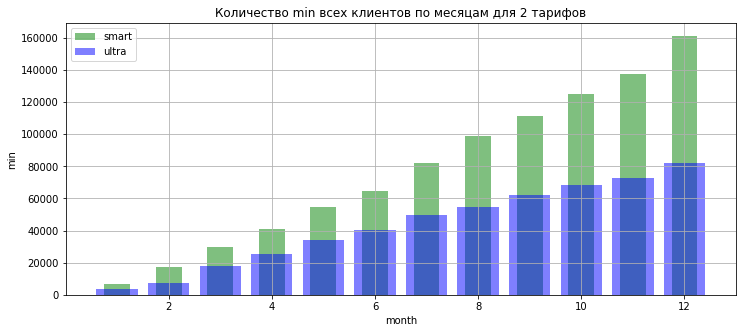

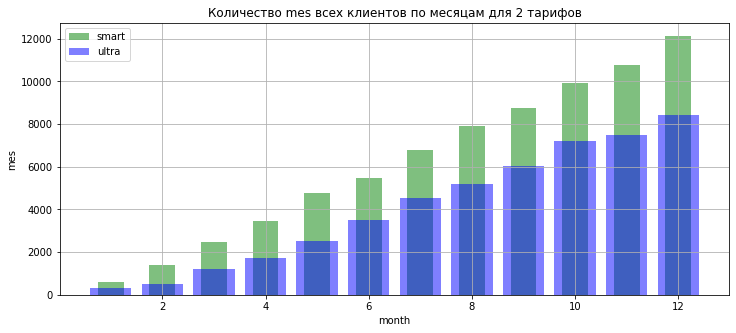

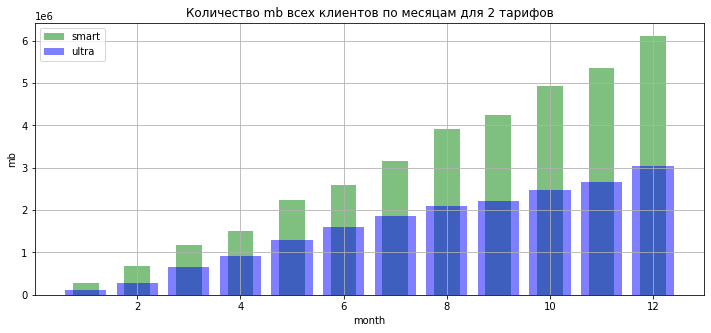

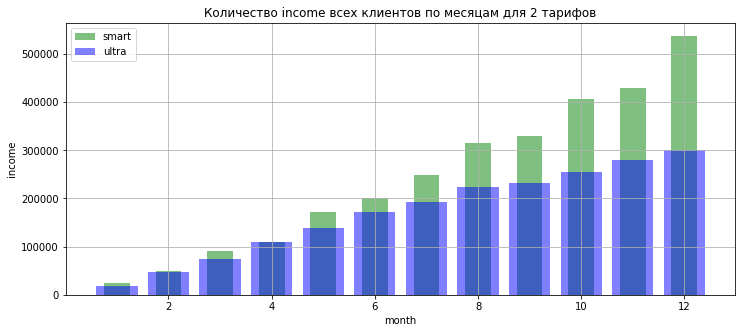

In [56]:
for param in ['min', 'mes', 'mb','income']:
    plt.figure(figsize=(12, 5))
    plt.bar(smart_all_clients_month['month'], smart_all_clients_month[param], label='smart', color='g', alpha=0.5, width=0.5)
    plt.bar(ultra_all_clients_month['month'], ultra_all_clients_month[param], label='ultra', color='b', alpha=0.5)

    plt.xlabel('month')
    plt.ylabel(param)
    plt.grid()
    plt.title(f'Количество {param} всех клиентов по месяцам для 2 тарифов')
    plt.legend()
    plt.show();

In [57]:
# Посмотрим сколько абонентов у каждого тарифа
users.tariff.value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

На графиках видим, что общий расход минут, сообщений, трафика всех абонентов тарифа 'smart' стабильно больше чем 'ultra' на 40-90%, но и абонентов у 'smart' в 2 с лишним раза больше, чем у 'ultra'. По выручке income надо отметить что : в первой половине года абоненты обоих тарифов приносят почти одинаковые суммы, а во второй - абоненты smart с каждым месяцем приносят выручки все больше и больше вплоть до декабря, где выручка уже почти в 2 раза больше, чем от тарифа ultra. По всем графикам видно, что гистограммы постоянно возрастают от меcяца к месяцу. Поэтому логично будет посчитать усредненные показатели расхода на одного абонента за каждый месяц и уже тогда сравнить тарифы.

*Расчитаем средние(медианные) показатели клиента по месяцам по обоим тарифам*

In [58]:
abonents[['min', 'mes', 'mb','income']].describe()

,min,mes,mb,income
count,3216.000000,3216.000000,3216.000000,3216.000000
mean,450.964241,38.257463,17216.871580,1542.024565
std,242.096312,36.149684,7588.071848,792.042574
min,0.000000,0.000000,0.000000,550.000000
25%,282.000000,9.000000,12496.250000,750.000000
50%,443.000000,30.000000,16962.000000,1669.500000
75%,589.000000,57.000000,21446.000000,1950.000000
max,1673.000000,224.000000,49789.000000,6770.000000


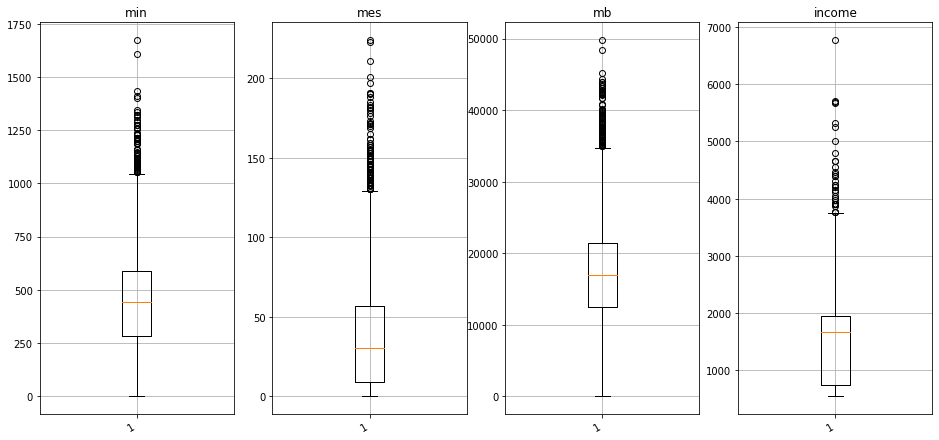

In [59]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))

p = {ax1:'min', ax2:'mes', ax3:'mb', ax4:'income'}
for ax in [ax1, ax2, ax3, ax4]:
    ax.boxplot(abonents[p[ax]])
    ax.grid()
    ax.set_title(p[ax])

fig.autofmt_xdate()

Сильных выбросов нет, вполне адекватные числа, поэтому для вычисления усредненных значений можно использовать и среднее и медиану. Выберем медиану.

Сгруппируем и создадим новую таблицу tar - с общими данными по тарифам

In [60]:
tar = abonents.groupby(['tariff', 'month'])['min', 'mes', 'mb','income'].mean().reset_index()
tar

/tmp/ipykernel_54/191451519.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tar = abonents.groupby(['tariff', 'month'])['min', 'mes', 'mb','income'].mean().reset_index()


,tariff,month,min,mes,mb,income
0,smart,1.0,203.852941,18.235294,8524.441176,721.323529
1,smart,2.0,298.689655,24.086207,11611.396552,844.844828
2,smart,3.0,390.051948,31.857143,15123.857143,1175.012987
3,smart,4.0,367.133929,30.741071,13479.482143,980.946429
4,smart,5.0,387.361702,33.773050,15825.198582,1220.205674
5,smart,6.0,395.640244,33.402439,15814.768293,1221.091463
6,smart,7.0,408.353234,33.751244,15763.512438,1241.860697
7,smart,8.0,421.468085,33.638298,16632.174468,1340.170213
8,smart,9.0,428.611538,33.638462,16324.526923,1270.715385
9,smart,10.0,426.136054,33.765306,16778.564626,1381.180272


Разделим новую таблицу на две smart и ultra - по каждому тарифу

In [61]:
smart = tar.query(' tariff=="smart" ')
ultra = tar.query(' tariff=="ultra" ')

In [62]:
smart

,tariff,month,min,mes,mb,income
0,smart,1.0,203.852941,18.235294,8524.441176,721.323529
1,smart,2.0,298.689655,24.086207,11611.396552,844.844828
2,smart,3.0,390.051948,31.857143,15123.857143,1175.012987
3,smart,4.0,367.133929,30.741071,13479.482143,980.946429
4,smart,5.0,387.361702,33.773050,15825.198582,1220.205674
5,smart,6.0,395.640244,33.402439,15814.768293,1221.091463
6,smart,7.0,408.353234,33.751244,15763.512438,1241.860697
7,smart,8.0,421.468085,33.638298,16632.174468,1340.170213
8,smart,9.0,428.611538,33.638462,16324.526923,1270.715385
9,smart,10.0,426.136054,33.765306,16778.564626,1381.180272


In [63]:
ultra

,tariff,month,min,mes,mb,income
12,ultra,1.0,428.111111,33.777778,13153.555556,1950.000000
13,ultra,2.0,297.125000,21.958333,11786.958333,1975.000000
14,ultra,3.0,489.648649,32.297297,17551.972973,2014.864865
15,ultra,4.0,458.018182,31.563636,16843.800000,2007.272727
16,ultra,5.0,510.328358,37.850746,19381.194030,2068.656716
17,ultra,6.0,479.702381,41.726190,18942.238095,2041.071429
18,ultra,7.0,545.791209,49.846154,20514.648352,2124.725275
19,ultra,8.0,510.775701,48.439252,19594.065421,2087.383178
20,ultra,9.0,539.443478,52.286957,19222.208696,2025.652174
21,ultra,10.0,558.081301,58.430894,20063.869919,2070.731707


In [64]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


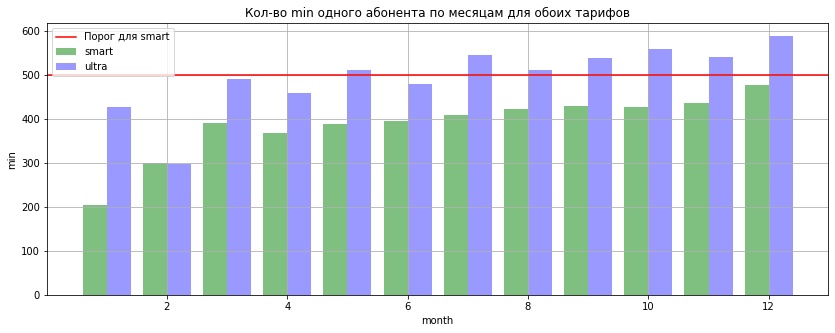

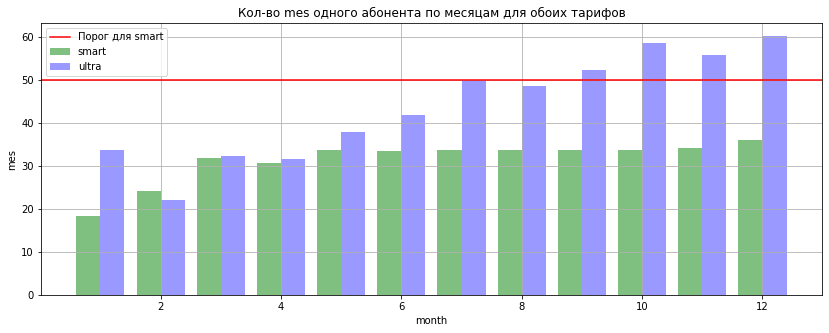

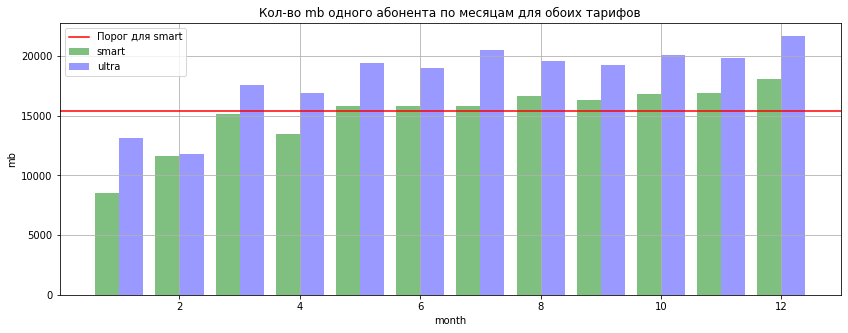

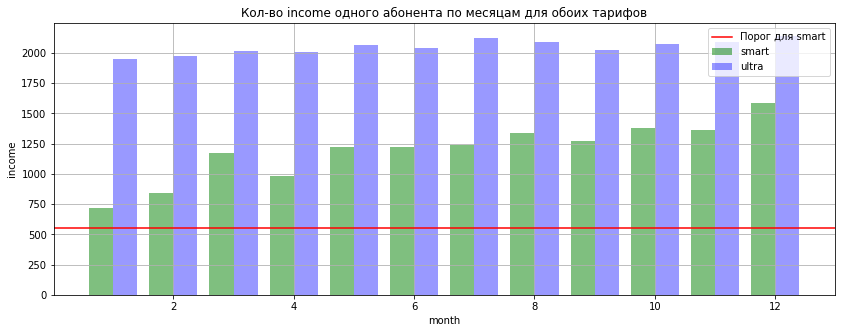

In [65]:
for param in ['min', 'mes', 'mb','income']:
    w = 0.4
    plt.figure(figsize=(14, 5))
    plt.bar(smart['month']-w/2, smart[param], label='smart', color='g', alpha=0.5, width=w)
    plt.bar(ultra['month']+w/2, ultra[param], label='ultra', color='b', alpha=0.4, width=w)

# porog- пороговое значение в smart, после которого идёт оплата сверх абонентской
    if param == 'min':
        porog=500
    elif param == 'mes':
        porog=50
    elif param == 'mb':
        porog=15360
    else:
        porog=550
        
    plt.axhline(y=porog, label='Порог для smart', color='red')  
    plt.xlabel('month')
    plt.ylabel(param)
    plt.grid()
    plt.title(f'Кол-во {param} одного абонента по месяцам для обоих тарифов')
    plt.legend()
    plt.show();

Рассчитаем усредненные значения за месяц, которые требуются абонентам в обоих тарифах

In [66]:
print('Медианные месячные значения абонента в течение 2018 года')
for parametr in ['min', 'mes', 'mb', 'income']:
    print(f'Кол-во {parametr}: smart = {round(smart[parametr].median())} / ultra = {round(ultra[parametr].median())}')

Медианные месячные значения абонента в течение 2018 года
Кол-во min: smart = 402 / ultra = 511
Кол-во mes: smart = 34 / ultra = 45
Кол-во mb: smart = 15820 / ultra = 19302
Кол-во income: smart = 1231 / ultra = 2055


Распределим абонентов по кол-ву использованых услуг, гистограммы

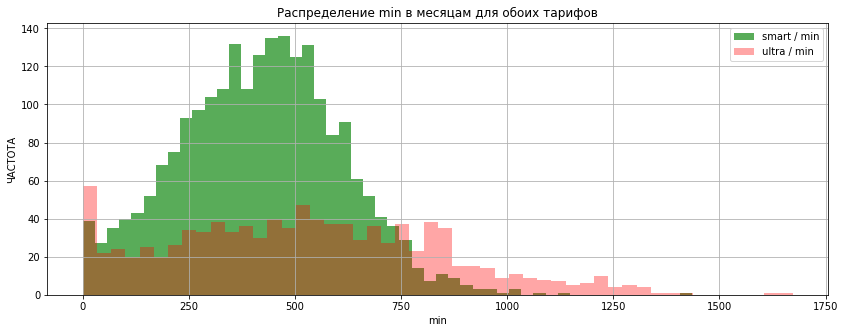

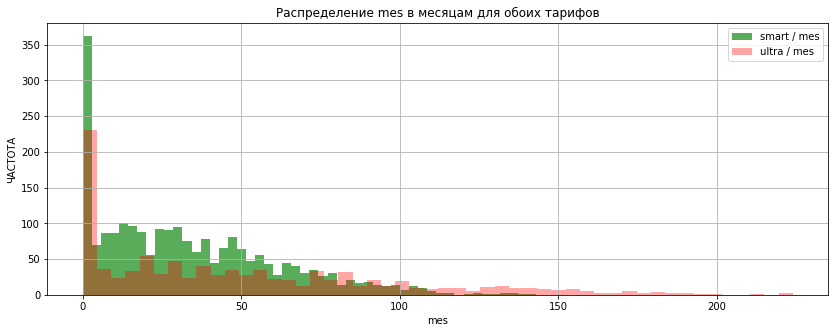

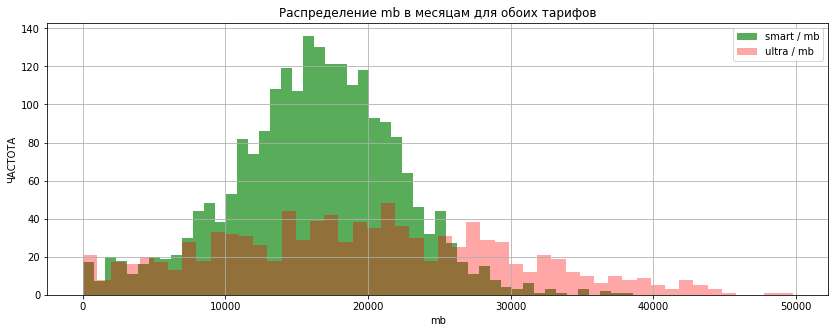

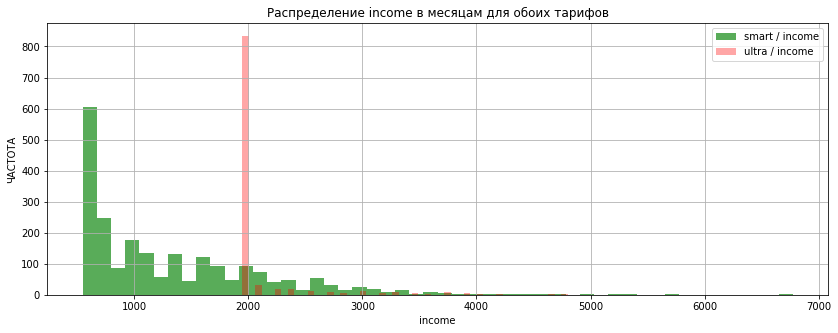

In [67]:
for param in ['min', 'mes', 'mb','income']:
    b = 50
    plt.figure(figsize=(14, 5))
    
    plt.hist(abonents.loc[abonents['tariff'] == "smart", param], label='smart / '+param, color='g', alpha=0.65, bins = b)
    plt.hist(abonents.loc[abonents['tariff'] == "ultra", param], label='ultra / '+param, color='r', alpha=0.35, bins = b)
    
    plt.ylabel('ЧАСТОТА')
    plt.xlabel(param)
    plt.grid()
    plt.title(f'Распределение {param} в месяцам для обоих тарифов')
    plt.legend()
    plt.show();

Определим среднее количество, дисперсию и стандартное отклонение

Создадим новый DataFrame stat_frame и запишем в него все расчитываемые статистические значения

Таблица stat_frame - статистика для выборки. 

Столбцы:
 - parameter - (min-минуты, mes-СМС, mb-трафик)
 - mean - среднее
 - var - дисперсия
 - std - стандартное отклонение
 - tariff - тариф (smart, ultra, all-по обоим тарифам)

In [68]:
stat_frame = pd.DataFrame(columns = ['parameter', 'mean', 'var', 'std', 'tariff'])

ind = 0
t = ['smart', 'ultra', 'all']
for param in ['min', 'mes', 'mb', 'income']:
    tariff_ind = 0
    for df in [smart, ultra, tar]:
        stat_frame.loc[ind, 'parameter'] = param
        stat_frame.loc[ind, 'mean'] = round(df[param].mean(),1)
        stat_frame.loc[ind, 'var'] = round(np.var(df[param], ddof=1),1) # Поскольку данные являются выборкой, это указано
        stat_frame.loc[ind, 'std'] = round(np.std(df[param], ddof=1),1) # в условии, то ипользуем параметр - ddof=1
        stat_frame.loc[ind, 'tariff'] = t[tariff_ind]
        ind +=1
        tariff_ind +=1
stat_frame

,parameter,mean,var,std,tariff
0,min,386.6,5198.3,72.1,smart
1,min,495.6,5925.4,77.0,ultra
2,min,441.1,8416.0,91.7,all
3,mes,31.4,26.0,5.1,smart
4,mes,43.7,150.5,12.3,ultra
5,mes,37.5,123.7,11.1,all
6,mb,15073.2,7124616.3,2669.2,smart
7,mb,18209.8,8831918.9,2971.9,ultra
8,mb,16641.5,10197858.2,3193.4,all
9,income,1195.6,58335.5,241.5,smart


Расчитаем доли стандартных отклонений в среднем - столбец %std

In [69]:
stat_frame['%std'] = stat_frame['std'] / stat_frame['mean'] * 100
stat_frame

,parameter,mean,var,std,tariff,%std
0,min,386.6,5198.3,72.1,smart,18.649767
1,min,495.6,5925.4,77.0,ultra,15.536723
2,min,441.1,8416.0,91.7,all,20.788937
3,mes,31.4,26.0,5.1,smart,16.242038
4,mes,43.7,150.5,12.3,ultra,28.146453
5,mes,37.5,123.7,11.1,all,29.6
6,mb,15073.2,7124616.3,2669.2,smart,17.70825
7,mb,18209.8,8831918.9,2971.9,ultra,16.320333
8,mb,16641.5,10197858.2,3193.4,all,19.189376
9,income,1195.6,58335.5,241.5,smart,20.199063


In [78]:
#Посчитаем среднее, дисперсию и ст. отклонение для тарифа smart.
 
smart_data = abonents.query('tariff == "smart"')
smart_data[['income']].describe()


,income
count,2230.000000
mean,1306.951121
std,813.189112
min,550.000000
25%,613.750000
50%,1046.000000
75%,1750.000000
max,6770.000000


In [80]:
#Посчитаем дисперсию и мат.ожидание для тарифов Smart:
 
variance_smart = np.var(smart_data[['income']])
variance_smart


income    660979.995369
dtype: float64

In [81]:
expectation_smart = variance_smart**0.5
expectation_smart

income    813.006762
dtype: float64

In [82]:
#То же сделаем для тарифов Ultra:
 
ultra_data = abonents.query('tariff == "ultra"')
ultra_data[['income']].describe()

,income
count,986.000000
mean,2073.681542
std,378.286997
min,1950.000000
25%,1950.000000
50%,1950.000000
75%,1950.000000
max,4800.000000


In [83]:
variance_ultra = np.var(ultra_data[['income']])
variance_ultra

income    142955.918868
dtype: float64

In [84]:
expectation_ultra = variance_ultra**0.5
expectation_ultra

income    378.095119
dtype: float64

**ВЫВОД**

В тарифе smart подавляющее большинство абонентов укладываются в лимит 500 минут разговора (среднее значение за 2018 год - 421 минута), да и в тарифе ultra не сильно ушли от этого значения - среднемесячное не больше 600 минут (не говоря уже об излишнем лимите в 3000! ). Также можно наблюдать, что расход минут постепенно возрастает в течение года. Исключение месяц февраль у тарифа ultra довольно сильное падение (хоть февраль самый короткий месяц, но снижение не пропорцианально - почти в 2 раза).Также надо отметить, что в тарифе smart в январе и феврале мало звонят - тоже в 2 раза меньше, чем в другие месяцы

СМС - мало популярная услуга (много абонентов которых вообще не пишут СМС или почти не пишут). Абоненты тарифа smart вполне укладываются в лимит 50 СМС (а среднее 28 СМС в месяц за год), даже абоненты тарифа ultra редко превышают порог в 50 СМС (скорее всего это какие-то интернет-сервисы или магазины). Видно, что на тарифе ultra СМС ближе к концу года пишут всё чаще и чаще, исключение - январь где наблюдаются, более высокая активность. В тарифе smart в первой половине года активность постепенно возрастает, а во второй держится примерно на одном уровне.

А вот с интернет-трафиком другая ситуация. Абоненты smart любят посидеть в интернете и частенько привышают лимит в 15360 МБ, даже среднее значение выше - 16073 МБ, также надо отметить, что опять начало года (январь и февраль) характеризовано низкой активностью в интернете (около 7,5 ГБ). В тарифе ultra опять сильный провал в феврале (в 2 раза), а в остально часть года идет очень постепенный рост; средний расход трафика на smart довольно не высокий не смотря на порог в 30 ГБ средний расход около 18,8 ГБ. Подавляющее большинство абонентов расходуют в месяц трафика от 11 до 23 ГБ

По выручке можно сказать: что выручка абонентов ultra в подавляющем большинстве случаев ограничивается тарифной платой(1950р), а абоненты smart напротив очень частенько платят сверх абонентской платы ( 982средн - 550абонплата = ) 482р - на 87,5% больше абонплаты!!, - и все это за счет Интернет-трафика) !

В принципе многие абоненты ultra могли бы перейти на тариф smart и платили бы меньше - если исходить из усредненных значений:
510мин (10 сверх 500) 10 3 = 30р Трафик 18831 МБ (3471 (4ГБ) сверх 15360 МБ) 4 200 = 800р
Итого = 550 + 30 + 800 = 1380р , а платят 1950 ! 

# Шаг 5. Проверяем гипотезы: #

-	средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
-	средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.


***Гипотеза №1***

In [71]:
# Запишем выручки в 2 таблицы ultra_income, smart_income для каждого тарифа
ultra_income_mean = abonents.query('tariff =="ultra"')['income'].values #reset_index()
smart_income_mean = abonents.query('tariff =="smart"')['income'].values #reset_index()


In [72]:
print('Дисперсия smart_income_mean =', np.var(smart_income_mean), '// Дисперсия ultra_income_mean =', \
      np.var(ultra_income_mean))

Дисперсия smart_income_mean = 660979.9953686984 // Дисперсия ultra_income_mean = 142955.91886821177


Дисперсия сильно отличается  - 660980 против 142956. Поэтому для проведения теста возьмем equal_var = False

Укажем критический уровень статистической значимости 5% alpha = 0.05

Нулевую гипотезу сформулируем так: средняя выручка пользователей тарифов «Ультра» (ultra_income) и «Смарт» (smart_income) равны; альтернативная гипотеза H₁ тогда будет звучать так - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [73]:
alpha = 0.05

results = st.ttest_ind(smart_income_mean, ultra_income_mean, equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.5941480288116247e-244
Отвергаем нулевую гипотезу


**Вывод**

Так как нулевая гипотеза неверна (средняя выручка пользователей 2 тарифов равны), то актуальна альтернативная гипотеза. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается, то есть гипотеза №1 подтверждается.

***Гипотеза №2***

In [74]:
# Запишем выручки в 2 таблицы moscow_income, other_income для Москвы и Остальных
moscow_income_mean = abonents.query('city == "Москва"')['income'].values
other_income_mean = abonents.query('city != "Москва"')['income'].values


In [75]:
print('Дисперсия moscow_income_mean =', np.var(moscow_income_mean), '// Дисперсия other_income_mean =', \
      np.var(other_income_mean))

Дисперсия moscow_income_mean = 555126.1226129793 // Дисперсия other_income_mean = 643914.3305976621


Дисперсия в данном случае не сильно отличается: 555126 против 643914 (около 16%). Поэтому equal_var = True

Укажем критический уровень статистической значимости 5% alpha = 0.05

Нулевую гипотезу сформулируем так: средняя выручка пользователей из Москвы (moscow_income_mean) и выручка пользователей из других регионов (other_income_mean) равны.
Альтернативная тогда - средняя выручка пользователей из Москвы и выручка пользователей из других регионов различаются.

In [76]:
alpha = 0.05

results = st.ttest_ind(moscow_income_mean, other_income_mean, equal_var = True)

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha): 
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.495399331911754
Не получилось отвергнуть нулевую гипотезу


**Вывод**

Так как нулевая гипотеза не отвергнута (средняя выручка пользователей Москвы и других городов равны), то это значит она актуальна, то есть гипотеза №2 не подтверждается.

# Шаг 6. Общий вывод: #

In [77]:
ultra_income = abonents.query('tariff =="ultra"')['income'].sum()
ultra_abonents = len(abonents.query('tariff =="ultra"'))
smart_income = abonents.query('tariff =="smart"')['income'].sum()
smart_abonents = len(abonents.query('tariff =="smart"'))
print(f'Выручка тарифа Ультра = {ultra_income} {ultra_income/149}')
print(f'Выручка тарифа Смарт = {smart_income} {smart_income/351}')

Выручка тарифа Ультра = 2044650.0 13722.48322147651
Выручка тарифа Смарт = 2914501.0 8303.421652421652


Итак, мы проанализировали 2 тарифа на небольшой выборке клиентов: 149 пользователь тарифа "Ультра", 351 пользователь тарифа "Смарт"
- Большая часть данных изначально в хорошем состоянии. Поэтому в процессе предобработки данных изменены только типы в столбцах с датами на datetime64, и проверена корректность данных. 

- Была создана новая таблица total - в которую сгруппировали данные по каждому абоненту за каждый месяц пользования.

По выручке можно сказать следующее: выручка абонентов "Ультра" в подавляющем большинстве случаев ограничивается абонентской платой(1950р), а абоненты "Смарт" напротив очень частенько выходят за рамки тарифа.

Проверены две гипотезы:
1) *Гипотеза №1*: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается: гипотеза подтвердилась

2) *Гипотеза №2*: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов: гипотеза не подтвердилась.

В итоге можно рекомендовать оператору скорректировать рекламный бюджет в сторону продвижения тарифа «Смарт». Он приносит больше выручки , его абоненты очень часто переплачивают сверх лимита, в отличие от абонентов тарифа «Ультра». Также по абонентской плате он более привлекателен для абонентов - а это очень весомый фактор для абонентов.